# 15. 의료영상 U-Net 용종검출 🧑‍⚕️👩‍⚕️⛑️

In [1]:
# 메모리 최적화
import tensorflow as tf

# GPU 메모리 설정 (세션 시작 시에만 가능)
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # 4GB로 제한
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [
                tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)
            ],  # 4096MB = 4GB
        )
    except RuntimeError as e:
        print(e)

# Mixed Precision 설정
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## 1.데이터 수집 및 Visualization

In [2]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


**• 데이터 준비**

In [3]:
# 데이터는 다음 파일 내에 위치 시켰습니다 !
# # !mkdir -p ~/aiffel/medical
# !ln -s ~/data/* ~/aiffel/medical

**• train 데이터와 test 데이터 분리**

In [3]:
DATASET_PATH = os.path.join(os.getenv("HOME"), "aiffel", "medical")

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [4]:
x_train_filenames = [
    os.path.join(img_dir, filename) for filename in os.listdir(img_dir)
]
x_train_filenames.sort()
y_train_filenames = [
    os.path.join(label_dir, filename) for filename in os.listdir(label_dir)
]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = (
    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)
)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


생각보다 이미지 개수가 많지 않습니다. 🥲
데이터 증강(Data Augmentation) 등을 고려해야 할 것 같습니다.

**• Visualization**

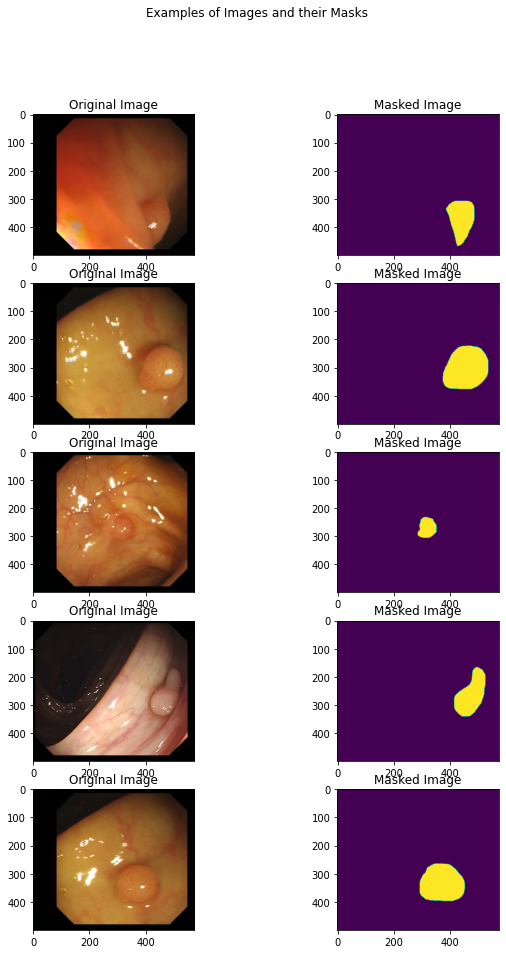

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")

plt.suptitle("Examples of Images and their Masks")
plt.show()

이미지를 확인해 보니 라벨은 클래스 값이 아니라, 입력이미지와 동일한 X-Y 사이즈를 가지고 용종 부위만 표시된 1채널짜리 이미지임!!<br>
즉,태스크는 Image classification이 아니라 **Semantic Segmentation** ❗️ <br>( 단순히 이미지 전체가 '무엇인지' 분류하는게 아니라 모든 픽셀을 분류해 자세한 영역을 구분하는 작업이 요구됨 )

## 2. 데이터 파이프라인 및 전처리

**• 하이퍼파라미터 설정**

In [8]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 2
max_epochs = 10

**•데이터 처리 과정:** <br>
tf.data로 데이터셋 구축 + 증강 처리하여, 적은 데이터에서도 모델 일반화 성능을 높이는 것이 목표!
<br>

	1.	이미지/레이블 파일을 바이트로 읽고 디코딩
    
	2.	_augment 함수를 map에 적용해 데이터 증강 수행 :
        •	크기 조정(resize)
        •	색조 변경(hue adjustment)
        •	수평 뒤집기(horizontal flip)
        •	가로/세로 이동(width/height shift)
        •	정규화(rescale)
        
	3.	데이터를 섞고(shuffle), 반복하며(repeat) 학습.
위에서 언급했듯 데이터가 부족하기 때문에 다양한 무작위 변환으로 데이터를 늘려 과적합 방지 및 일반화 성능 향상을 시켜줘야함.

**• 먼저, 파일 경로를 읽어 BMP로 디코딩한 뒤, 스케일과 크기를 조정하는 함수를 구현**

In [9]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.0
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

**• 이미지 데이터를 임의로 이동(Shifting)하여 데이터 증강(Data Augmentation) 수행** <br>
입력이미지와 라벨의 쌍을 동일하게 shift시켜주어야 함

In [10]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform(
                [], -width_shift_range * img_shape[1], width_shift_range * img_shape[1]
            )
        if height_shift_range:
            height_shift_range = tf.random.uniform(
                [],
                -height_shift_range * img_shape[0],
                height_shift_range * img_shape[0],
            )
        output_img = tfa.image.translate(
            output_img, [width_shift_range, height_shift_range]
        )
        label_img = tfa.image.translate(
            label_img, [width_shift_range, height_shift_range]
        )
    return output_img, label_img

**• 이미지를 무작위로 좌우 반전(Flipping)하여 데이터 증강(Data Augmentation) 수행**

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(
            tf.less(flip_prob, 0.5),
            lambda: (
                tf.image.flip_left_right(tr_img),
                tf.image.flip_left_right(label_img),
            ),
            lambda: (tr_img, label_img),
        )
    return tr_img, label_img

**• 여러 증강 기법( 리사이즈, 색조 변경, 좌우 반전, 가로/세로 이동, 스케일 조정)을 조합해 _augment() 함수로 통합**

In [12]:
def _augment(
    img,
    label_img,
    resize=None,  # Resize the image to some size e.g. [256, 256]
    scale=1,  # Scale image e.g. 1 / 255.
    hue_delta=0.0,  # Adjust the hue of an RGB image by random factor
    horizontal_flip=True,  # Random left right flip,
    width_shift_range=0.05,  # Randomly translate the image horizontally
    height_shift_range=0.05,
):  # Randomly translate the image vertically
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

**• tf.data.Dataset으로 Train/Test 데이터셋을 나눔** <br>
(⚠️ Train에만 데이터 증강을 적용)

In [13]:
def get_baseline_dataset(
    filenames,
    labels,
    preproc_fn=functools.partial(_augment),
    threads=4,
    batch_size=batch_size,
    is_train=True,
):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:  # 학습을 진행할시에만 위에 augment를 진행합니다.
        # if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_dataset = get_baseline_dataset(
    x_train_filenames, y_train_filenames  # 학습 데이터
)  # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames, y_test_filenames, is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

**• 학습 데이터 일부를 시각화하여 증강 결과를 검토**

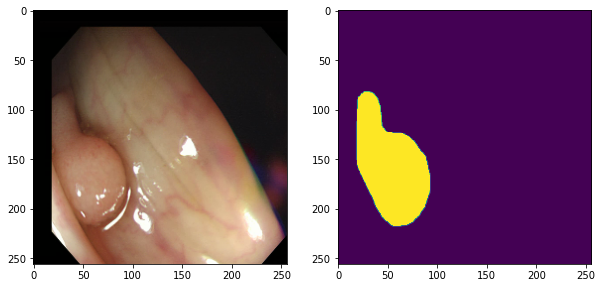

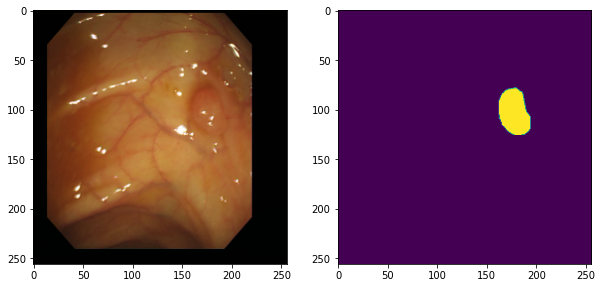

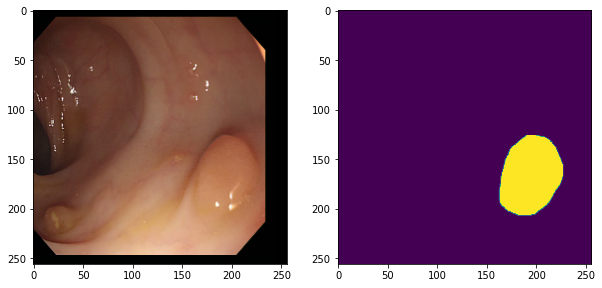

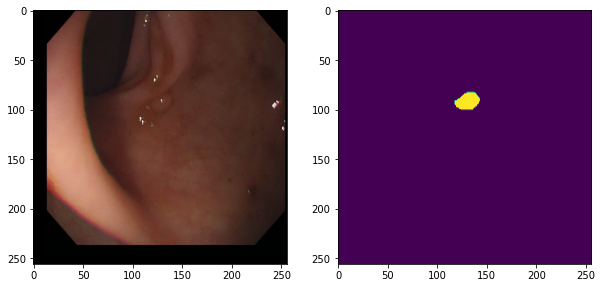

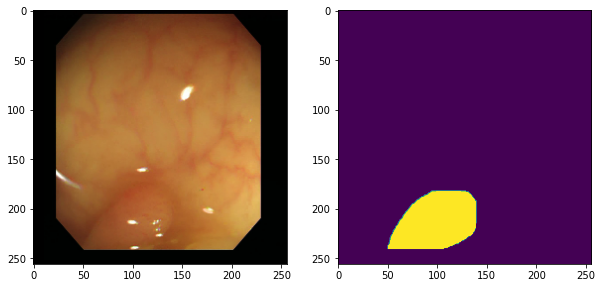

In [15]:
for images, labels in train_dataset.take(5):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## 3. 모델 설계하기

**✅ 목표: 두 개의 네트워크(Encoder-Decoder, U-Net)를 만들어 성능을 비교한다.**

## 3-1.Encoder-Decoder<br>
**•Encoder-Decoder 구조 설명:** <br>
	•	Encoder: 입력 이미지를 점점 작은 차원으로 압축.<br>
	•	Decoder: 압축된 정보를 다시 복원하여 레이블(label)과 같게 재구성.<br>
	•	End-to-End 학습: 생성된 출력과 실제 레이블 간의 차이를 줄이도록 전체 네트워크를 학습.<br>
**Encoder 설계:**<br>
	•	입력: [batch_size, 256, 256, 3]<br>
	•	단계별 출력:<br>
	•	Conv1 → [batch_size, 128, 128, 64]<br>
	•	Conv2 → [batch_size, 64, 64, 128]<br>
	•	Conv3 → [batch_size, 32, 32, 256]<br>
	•	최종 출력 → [batch_size, 16, 16, 512]<br>
	•	Conv-Norm-Activation 조합 사용.<br>
	•	다운샘플링은 Pooling 또는 stride=2 Convolution 중 선택.<br>
    
**Decoder 설계:**<br>
	•	입력: [batch_size, 16, 16, 512] (Encoder 출력과 동일)<br>
	•	단계별 출력:<br>
	•	ConvTranspose1 → [batch_size, 32, 32, 256]<br>
	•	ConvTranspose2 → [batch_size, 64, 64, 128]<br>
	•	ConvTranspose3 → [batch_size, 128, 128, 64]<br>
	•	최종 출력 → [batch_size, 256, 256, 1]<br>
	•	Encoder의 구조를 거꾸로(mirror) 만들어 복원.<br>
    
**구현 방법:**<br>
	•	tf.keras.Sequential()을 이용해 네트워크를 설계.


In [15]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name="encoder")

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding="same"))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation("relu"))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding="same"))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation("relu"))  # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding="same"))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation("relu"))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding="same"))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation("relu"))  # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding="same"))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation("relu"))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding="same"))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation("relu"))  # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding="same"))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation("relu"))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding="same"))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation("relu"))  # conv4-outputs: [batch_size, 16, 16, 512]

In [16]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)  # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [17]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name="decoder")

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding="same"))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation("relu"))  # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding="same"))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation("relu"))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same"))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation("relu"))  # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding="same"))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation("relu"))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same"))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation("relu"))  # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding="same"))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation("relu"))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same"))
decoder.add(layers.BatchNormalization())
decoder.add(
    layers.Activation("relu")
)  # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding="same"))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation("relu"))

decoder.add(
    layers.Conv2DTranspose(1, 1, strides=1, padding="same", activation="sigmoid")
)

In [18]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)  # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


**• 지금까지 만든 Encoder와 Decoder를 연결하여 최종 모델을 구성**

In [19]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

## 3-2. U-Net

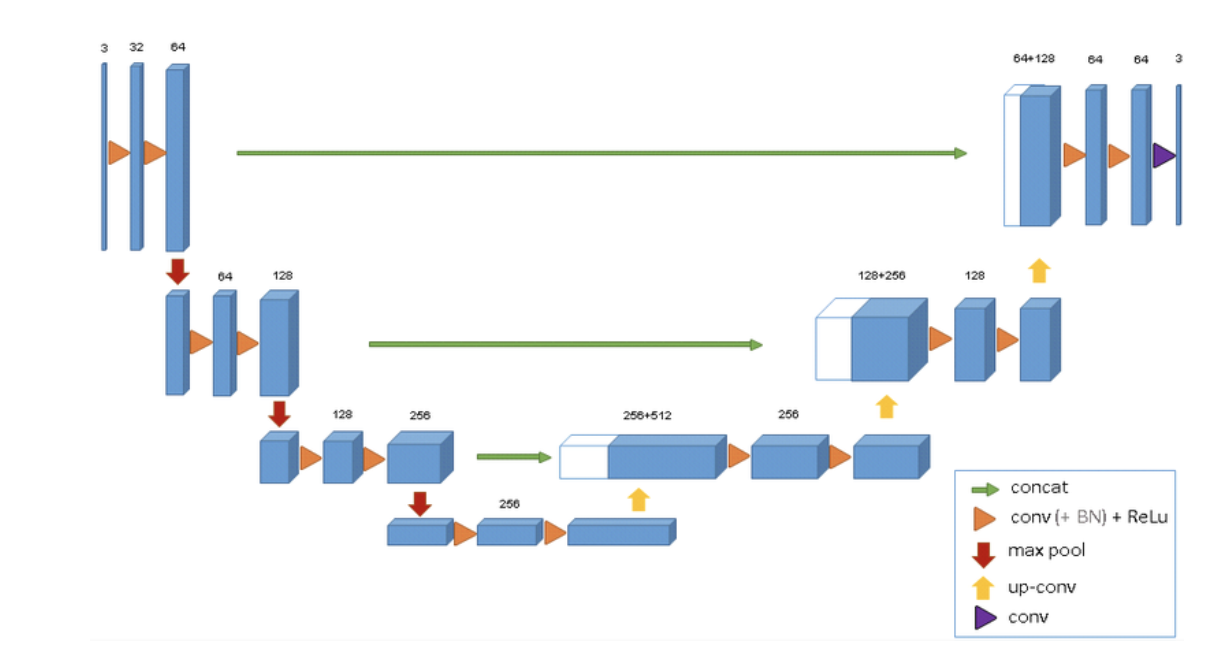

**목표: 위 그림과 같은 U-Net 모델을 구현한다.** <br>
	• 차이점:<br>
	• 논문 원본은 padding=‘valid’ (zero padding) → Encoder/Decoder 크기 약간 차이 발생<br>
	• 하지만, 여기선 **padding=‘same’**을 사용해 Encoder와 Decoder 레이어 크기를 동일하게 맞춘다.<br>
	• 이유:<br>
	• 성능에는 큰 영향이 없고,<br>
	• 구현이 더 간편해지고,<br>
	• 모델 개선(업그레이드)도 쉽게 할 수 있다.<br>

⚠️<br>
• U-Net은 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않기 <br>(Skip Connection이 존재) 때문에 일반적인 Sequential 방식으로 구현할 수 없다.<br>
• 따라서, tf.keras.Model을 subclassing하여 직접 모델을 정의해야 한다.<br>
• 이 방식을 통해 복잡한 연결(Encoder 출력과 Decoder 입력 + Skip 연결)을 자유롭게 설계할 수 있다.<br>

<참고><br>
✅ U-Net의 핵심 구조<br>
	•	U-Net은 Encoder에서 feature를 압축하면서 저장하고<br>
	•	Decoder로 복원할 때, Encoder에서 저장한 feature map을 복원 과정에 직접 연결해서 사용함. <br>
	•	이 연결(Bridge)이 바로 Skip Connection

즉,
“Encoder의 중간 레이어 output을 Decoder에 concat(붙여넣기)한다.”

In [16]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding="same")
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [17]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder


class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding="same")
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [18]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation="sigmoid")

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

**• U-Net model 생성**

In [19]:
unet_model = UNet()

**• metrics과 loss functions 정의하기**<br>
	•	사용할 Loss:<br>
	•	**Binary Cross Entropy**: 픽셀별 이진 분류용 기본 손실 함수<br>
	•	**Dice Loss**: Segmentation 정답과 예측 간의 겹침 정도를 기반으로 계산<br>
	•	**Dice Coefficient 수식**:<br>
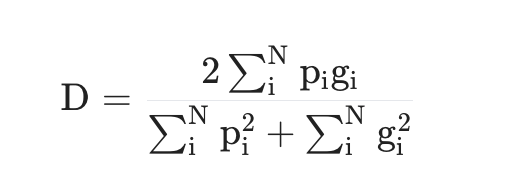
    •	**전략**:<br>
	•	Cross Entropy Loss와 Dice Loss를 함께 사용하여 학습한다.<br>
	•	이 조합을 통해 **mean IoU (교차분할 정확도)**를 높인다.<br>

In [22]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2.0 * intersection + smooth) / (
        tf.reduce_sum(tf.square(y_true_f)) + tf.reduce_sum(tf.square(y_pred_f)) + smooth
    )

    return score

Dice Loss가 최대화되는 방향으로 구해지도록, 아래와 같이 사용

In [23]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

기존에 사용하던 Binary Crossentropy Loss에 새로 구현한 Dice Loss를 추가하여 새로운 Loss Function을 구성

In [24]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + dice_loss(
        y_true, y_pred
    )
    return loss

In [36]:
optimizer = tf.keras.optimizers.Adam()  # 기본 Learning rate 사용

**• 모델 선택하기**  <br>
먼저 1.**Encoder-Decoder model**를 학습 !

In [24]:
print("select the Encoder-Decoder model")
model = ed_model
checkpoint_dir = os.path.join(DATASET_PATH, "train_ckpt/ed_model")

# print('select the U-Net model')
# model = unet_model
# checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the Encoder-Decoder model


In [25]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


**callback**	
    •	사용할 Callback:<br>
     **1. ModelCheckpoint 함수** <br>
→ 특정 모니터링 지표를 기준으로 모델 파라미터를 저장 <br>
	•	**2. LearningRateScheduler 함수:** <br>
→ 학습 과정 중 주어진 함수에 따라 Learning Rate를 동적으로 조정 <br>
	•	특징: <br>
	•	cos_decay 함수를 사용해, Cosine 형태로 Learning Rate를 감소시킴

In [27]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor="val_loss",
    mode="auto",
    save_best_only=True,
    verbose=0,
)

In [28]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## 4-1. **Encoder-Decoder model** 모델 학습시키기

In [29]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0, :, :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

**• model.fit() 함수를 이용해 모델을 학습**
  
	•학습 데이터 구성:
	•Train dataset: 학습용으로 사용
	•Test dataset: Validation dataset으로 함께 사용 
    (데이터 부족 문제 때문에)
	
    •학습 계획:
	•10 Epoch만 학습을 진행
	•이후에는 미리 학습된 모델을 불러와 추가 작업을 진행할 예정

In [30]:
history = model.fit(
    train_dataset,
    epochs=max_epochs,  # 10
    steps_per_epoch=num_train_examples // batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples // batch_size,
    callbacks=[cp_callback, lr_callback],
)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 12s 220ms/step - loss: 1.4335 - dice_loss: 0.8157 - val_loss: 3.0567 - val_dice_loss: 0.9986
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 8s 209ms/step - loss: 1.1953 - dice_loss: 0.7894 - val_loss: 1.3943 - val_dice_loss: 0.8212
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 8s 207ms/step - loss: 1.1073 - dice_loss: 0.7827 - val_loss: 1.3538 - val_dice_loss: 0.8152
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 8s 205ms/step - loss: 1.0434 - dice_loss: 0.7455 - val_loss: 1.2960 - val_di

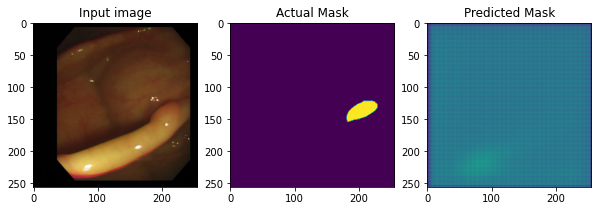

In [31]:
# print sample image after training
print_images()

**•history 시각화**

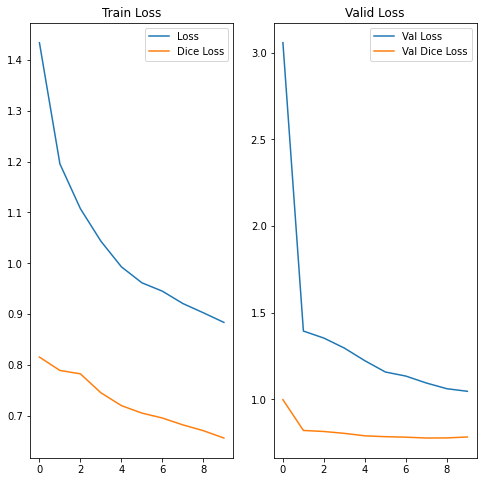

In [32]:
dice_loss = history.history["dice_loss"]
loss = history.history["loss"]
val_dice_loss = history.history["val_dice_loss"]
val_loss = history.history["val_loss"]

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Loss")
plt.plot(epochs_range, dice_loss, label="Dice Loss")
plt.legend(loc="upper right")
plt.title("Train Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.plot(epochs_range, val_dice_loss, label="Val Dice Loss")
plt.legend(loc="upper right")
plt.title("Valid Loss")
plt.show()

**• 저장된 모델의 (= 미리 학습된 모델) 가중치를 불러오기**

In [33]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
checkpoint_dir = os.path.join(DATASET_PATH, "ed_ckpt/ed_model")
# checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

**•불러온 가중치를 이용해 Test 데이터셋에서 모델을 평가** <br>
	•평가 방법: <br>
	•	1. 정량적 평가: <br>
	•	mean IoU(교집합/합집합 비율의 평균)를 metric으로 사용하여 수치로 평가 <br>
    	•	meanIoU 개념: <br>
	•	각 이미지에 대해 IoU를 계산한 후, 그 값을 평균낸 지표. <br>
	•	Segmentation 모델 성능을 정량적으로 평가하는 데 적합 <br>
   <br>
	•	2. 정성적 평가: <br>
	•	실제 예측된 segmentation 이미지를 분석하여 결과를 시각적으로 확인 <br>

In [34]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

**• 테스트 데이터셋을 불러와서 meanIoU 값을 구해보기** <br>
(이 값이 우리가 훈련시킨 모델에 대한 정량적 성능 metric이 됨)

In [35]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.6658949390480631


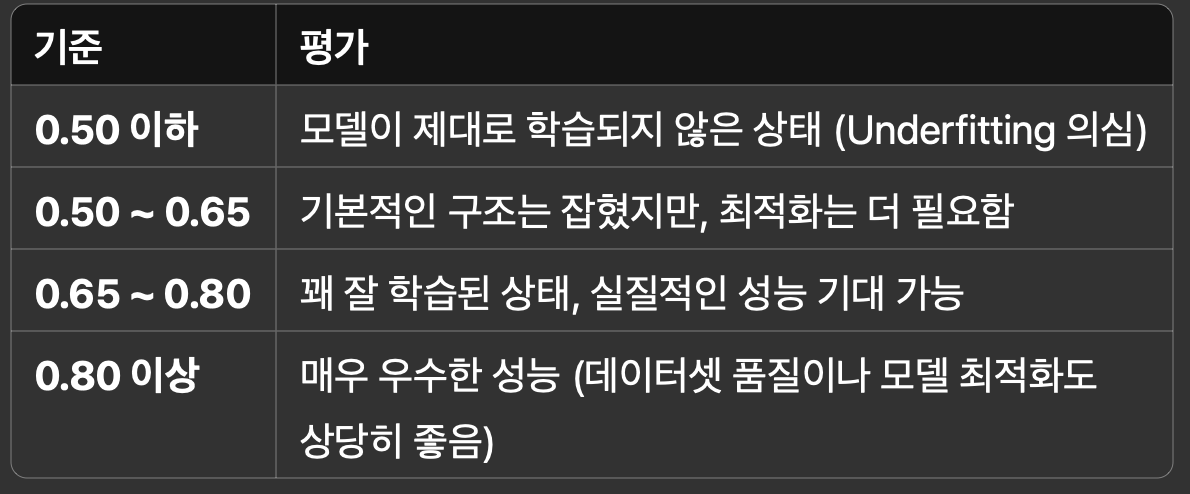

**• Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인**

In [36]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i, :, :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

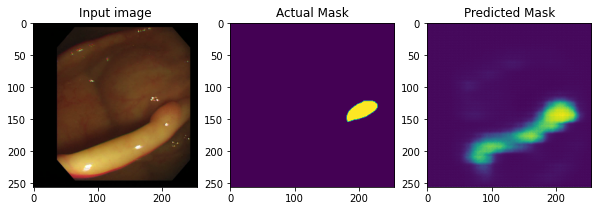

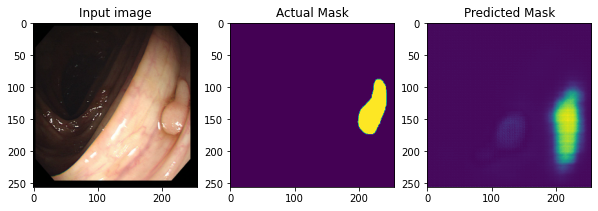

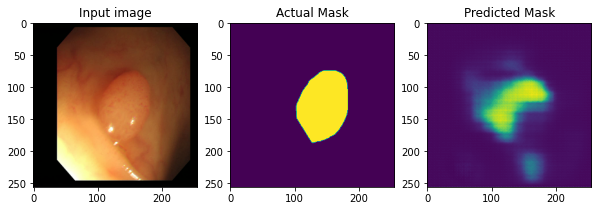

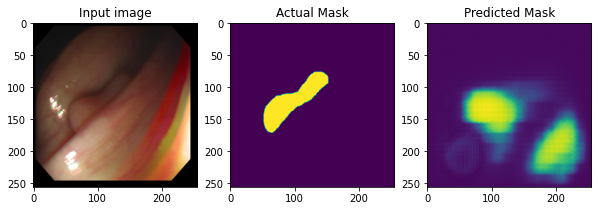

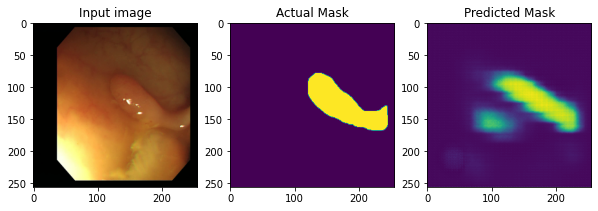

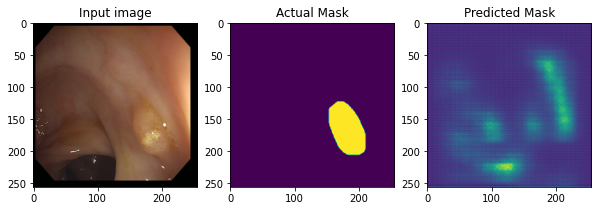

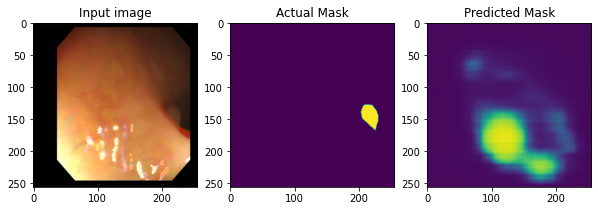

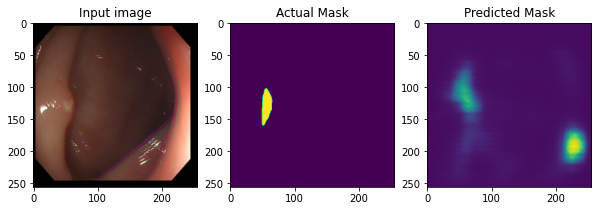

In [37]:
print_images()

## 4-2. **U-Net** 모델 학습시키기

In [24]:
# print('select the Encoder-Decoder model')
# model = ed_model
# checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print("select the U-Net model")
model = unet_model
checkpoint_dir = os.path.join(DATASET_PATH, "train_ckpt/unet_model")

select the U-Net model


**• Compile**

In [25]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(2, 256, 256, 1)


In [26]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

**• Callbacks 등 위에 Enconder-Decoder 모델과 똑같이 정의**

In [27]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor="val_loss",
    mode="auto",
    save_best_only=True,
    verbose=0,
)

In [28]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [29]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0, :, :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [30]:
history = model.fit(
    train_dataset,
    epochs=max_epochs,  # 10
    steps_per_epoch=num_train_examples // batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples // batch_size,
    callbacks=[cp_callback, lr_callback],
)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
120/120 [==============================] - 35s 136ms/step - loss: 1.3423 - dice_loss: 0.7408 - val_loss: 1.9782 - val_dice_loss: 0.9777
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
120/120 [==============================] - 17s 129ms/step - loss: 1.0352 - dice_loss: 0.6960 - val_loss: 31.3823 - val_dice_loss: 0.8718
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
120/120 [==============================] - 17s 129ms/step - loss: 1.0170 - dice_loss: 0.6563 - val_loss: 3.3427 - val_dice_loss: 0.7932
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
120/120 [==============================] - 17s 128ms/step - loss: 0.8765 - dice_loss: 0.6228 - val_loss: 1.1

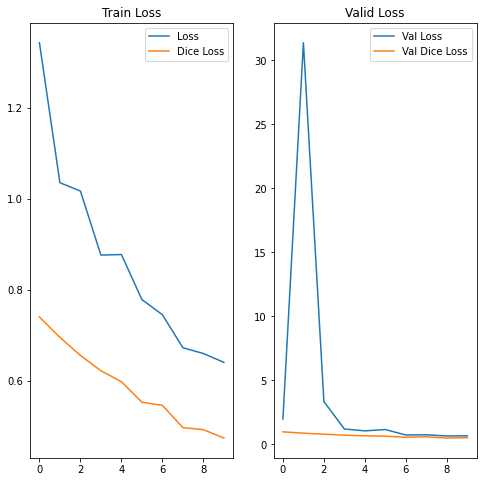

In [31]:
dice_loss = history.history["dice_loss"]
loss = history.history["loss"]
val_dice_loss = history.history["val_dice_loss"]
val_loss = history.history["val_loss"]

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Loss")
plt.plot(epochs_range, dice_loss, label="Dice Loss")
plt.legend(loc="upper right")
plt.title("Train Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.plot(epochs_range, val_dice_loss, label="Val Dice Loss")
plt.legend(loc="upper right")
plt.title("Valid Loss")
plt.show()

In [32]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir = os.path.join(DATASET_PATH, "unet_ckpt/unet_model")

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

In [33]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [34]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9403284496029041


In [35]:
# Define print function
def print_images():
    batch_size = 2  # 메모리 때문에 변경 (배치 크기 2)
    images_to_show = 8  # 총 8개의 이미지를 출력하려면 배치 4번 반복

    # 이미지 8장을 출력할 때까지 배치를 반복
    for i, (test_images, test_labels) in enumerate(
        test_dataset.take(images_to_show // batch_size)
    ):
        predictions = model(test_images, training=False)

        for j in range(batch_size):
            # 8개 이미지에 대해 출력
            plt.figure(figsize=(10, 20))

            # 첫 번째 열: Input image
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[j, :, :, :])
            plt.title("Input image")

            # 두 번째 열: Actual mask (Ground truth)
            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[j, :, :, 0])
            plt.title("Actual Mask")

            # 세 번째 열: Predicted mask (정규화)
            plt.subplot(1, 3, 3)
            pred_img = tf.cast(
                predictions[j, :, :, 0] * 255.0, dtype=tf.uint8
            )  # 예측값을 0-255 범위로 정규화
            plt.imshow(pred_img)
            plt.title("Predicted Mask")

            plt.show()

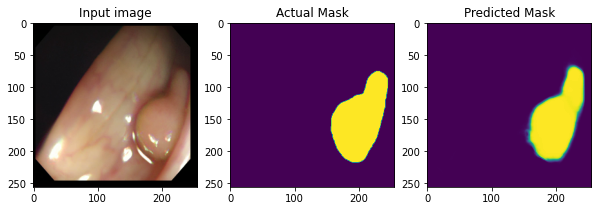

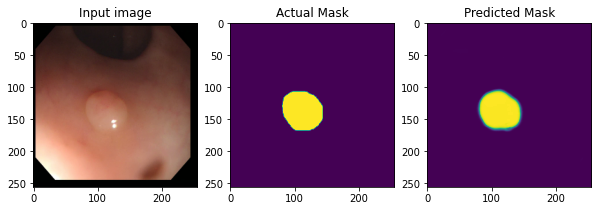

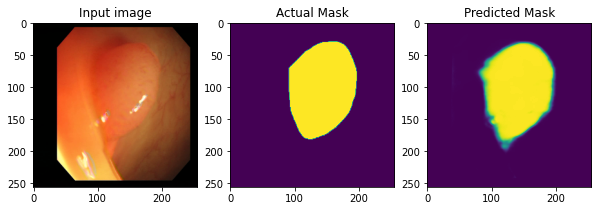

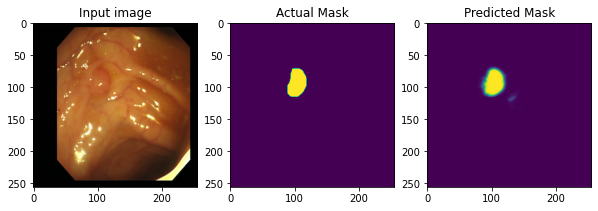

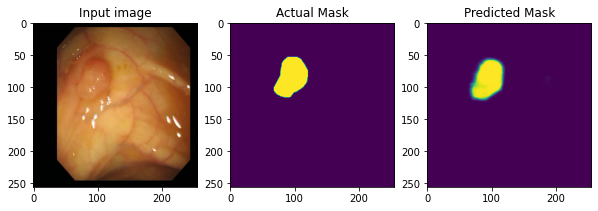

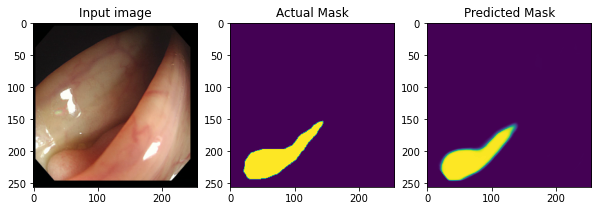

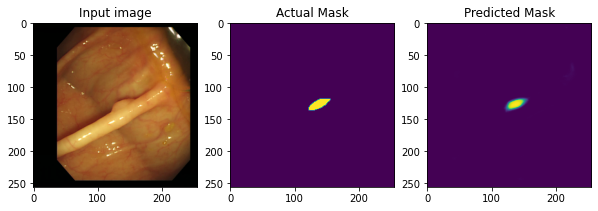

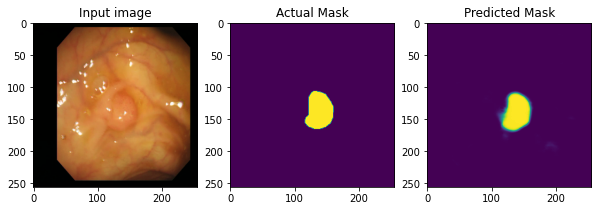

In [36]:
print_images()

## 5. 프로젝트: U-Net 성능 개선해 보기

In [16]:
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


## 5-1. 데이터셋 구성

위의 데이터셋 구성과 동일 

## 5-2.pretrained model을 활용한 U-Net 모델 구성

❗️ <br>
**VGG16 모델은 전체적인 구조가 U-Net의 인코더 부분과 유사합니다. <br>
따라서 VGG16을 U-Net의 인코더로 대체하면 자연스럽고 효율적으로 모델을 구성할 수 있습니다.<br>
단, VGG16 전체를 그대로 사용하는 것이 아니라,<br>
중간 레이어들의 출력을 뽑아 Decoder와 skip connection으로 연결하기 위해<br>
필요한 출력만 골라내는 서브 모델(vgg16_act)을 새로 정의합니다.<br>
이렇게 하면 기존 U-Net에서 encoder 레이어가 맡았던 역할을<br>
vgg16_act가 대신 수행하게 되어, 보다 간결하고 강력한 구조를 만들 수 있습니다.**<br>

In [32]:
vgg16 = tf.keras.applications.VGG16(
    input_shape=img_shape, include_top=False, weights="imagenet"
)
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float16 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float16 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float16 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float16 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float16 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float16 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float16 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float16 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float16 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float16 (created by layer 'block3_pool')>,


In [33]:
class Vgg16UNet(tf.keras.Model):
    def __init__(
        self, img_shape=(256, 256, 3)
    ):  # 별표를 밑줄로 수정하고 img_shape 파라미터 추가
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(
            input_shape=img_shape, include_top=False, weights="imagenet"
        )
        self.vgg16.trainable = False  # 이 부분은 정확히 추가하셨습니다
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = tf.keras.models.Model(
            inputs=self.vgg16.input,
            outputs=[
                layer_outputs[2],
                layer_outputs[5],
                layer_outputs[9],
                layer_outputs[13],
                layer_outputs[17],
            ],
        )
        # center는 VGG16의 마지막 층에서 얻으므로 별도로 정의할 필요 없음
        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)
        self.output_conv = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")

    def call(self, inputs, training=True):
        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs)
        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)
        return outputs

In [34]:
from tensorflow.keras import layers, models
import tensorflow as tf


# ConvBlock: Conv → BatchNorm → ReLU 두 번
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, (3, 3), padding="same", use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.Activation("relu")

        self.conv2 = layers.Conv2D(filters, (3, 3), padding="same", use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.Activation("relu")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)

        return x


# DecoderBlock: 업샘플 + Dropout + Skip 연결 + ConvBlock
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters, dropout_rate=0.3):
        super(DecoderBlock, self).__init__()
        self.up = layers.Conv2DTranspose(
            filters, (2, 2), strides=(2, 2), padding="same"
        )
        self.dropout = layers.Dropout(dropout_rate)
        self.conv_block = ConvBlock(filters)

    def call(self, inputs, skip_features):
        x = self.up(inputs)
        x = tf.concat([x, skip_features], axis=-1)
        x = self.dropout(x)
        x = self.conv_block(x)
        return x


# VGG16 기반 U-Net 수정 버전
class Vgg16UNet(tf.keras.Model):
    def __init__(self, img_shape=(256, 256, 3)):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(
            input_shape=img_shape, include_top=False, weights="imagenet"
        )

        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(
            inputs=self.vgg16.input,
            outputs=[
                layer_outputs[2],  # block1_pool (128x128x64)
                layer_outputs[5],  # block2_pool (64x64x128)
                layer_outputs[9],  # block3_pool (32x32x256)
                layer_outputs[13],  # block4_pool (16x16x512)
                layer_outputs[17],  # block5_pool (8x8x512)
            ],
        )

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512, dropout_rate=0.5)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, (1, 1), activation="sigmoid")

    def call(self, inputs):
        # 수정된 연결
        encoder1, encoder2, encoder3, encoder4, center_input = self.vgg16_act(inputs)

        center = self.center(center_input)  # center_input을 ConvBlock에 통과시킴

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)
        return outputs

In [35]:
import tensorflow as tf
from tensorflow.keras import losses


#
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2.0 * intersection + smooth) / (
        tf.reduce_sum(tf.square(y_true_f)) + tf.reduce_sum(tf.square(y_pred_f)) + smooth
    )

    return score


def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    bce = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred))
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [37]:
model = Vgg16UNet()

In [38]:
print("select the Vgg16-UNet model")
model = Vgg16UNet()
checkpoint_dir = os.path.join(DATASET_PATH, "train_ckpt/vgg16_unet_model")

select the Vgg16-UNet model


In [39]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(2, 256, 256, 1)


In [40]:
model.summary()

Model: "vgg16u_net_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
model_3 (Functional)         [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_15 (ConvBlock)    multiple                  14163968  
_________________________________________________________________
decoder_block_12 (DecoderBlo multiple                  9179648   
_________________________________________________________________
decoder_block_13 (DecoderBlo multiple                  2296064   
_________________________________________________________________
decoder_block_14 (DecoderBlo multiple                  574592    
_________________________________________________________________
decoder_block_15 (DecoderBlo multiple                 

1. **ConvBlock 구조 개선**: 
   - BatchNormalization 레이어 추가
   - `use_bias=False` 설정 (BatchNorm과 함께 사용할 때 권장됨)
   - 각 컨볼루션 후 명시적인 활성화 레이어 분리

2. **DecoderBlock 개선**:
   - Dropout 레이어 추가 (과적합 방지에 도움)
   - 각 디코더마다 서로 다른 dropout_rate 설정 가능

3. **Vgg16UNet 개선**:
   - 명시적인 img_shape 파라미터
   - VGG16 레이어 출력에 대한 주석 추가 (어떤 레이어인지 명확히 함)
   - 더 강한 드롭아웃(0.5)을 사용한 마지막 디코더
   - center 블록을 실제로 활용하도록 수정

이 구조의 장점은:
- BatchNormalization을 통한 학습 안정화 및 속도 향상
- Dropout을 통한 과적합 방지
- VGG16 레이어 선택에 대한 명확한 주석
- ConvBlock 및 DecoderBlock 구조의 일관성

In [41]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor="val_loss",
    mode="auto",
    save_best_only=True,
    verbose=0,
)

In [42]:
cos_decay = tf.keras.experimental.CosineDecay(1e-4, max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [43]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0, :, :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

## 5-3 : 학습과 테스트, 시각화

In [44]:
history = model.fit(
    train_dataset,
    epochs=max_epochs,  # 10
    steps_per_epoch=num_train_examples // batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples // batch_size,
    callbacks=[cp_callback, lr_callback],
)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(1e-04, shape=(), dtype=float32).
120/120 [==============================] - 15s 87ms/step - loss: 1.2487 - dice_loss: 0.6132 - val_loss: 25.7177 - val_dice_loss: 0.8774
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(9.7552824e-05, shape=(), dtype=float32).
120/120 [==============================] - 11s 84ms/step - loss: 0.5946 - dice_loss: 0.3588 - val_loss: 1.2192 - val_dice_loss: 0.4443
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(9.045084e-05, shape=(), dtype=float32).
120/120 [==============================] - 11s 83ms/step - loss: 0.4626 - dice_loss: 0.2837 - val_loss: 0.8279 - val_dice_loss: 0.3665
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(7.938926e-05, shape=(), dtype=float32).
120/120 [==============================] - 11s 83ms/step - loss: 0.3741 - dice_loss: 0.2329 - val_loss: 0.3484 -

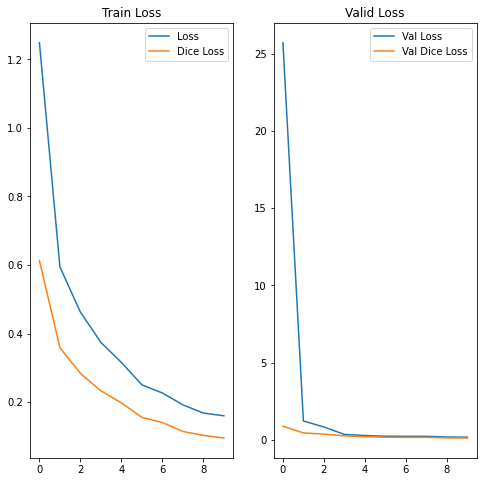

In [45]:
dice_loss = history.history["dice_loss"]
loss = history.history["loss"]
val_dice_loss = history.history["val_dice_loss"]
val_loss = history.history["val_loss"]

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Loss")
plt.plot(epochs_range, dice_loss, label="Dice Loss")
plt.legend(loc="upper right")
plt.title("Train Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.plot(epochs_range, val_dice_loss, label="Val Dice Loss")
plt.legend(loc="upper right")
plt.title("Valid Loss")
plt.show()

In [46]:
checkpoint_dir = os.path.join(DATASET_PATH, "train_ckpt/vgg16_unet_model")
model.load_weights(checkpoint_dir)

In [47]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [48]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.8871544134698394


In [49]:
# Define print function
def print_images():
    batch_size = 2  # 메모리 때문에 변경 (배치 크기 2)
    images_to_show = 8  # 총 8개의 이미지를 출력하려면 배치 4번 반복

    # 이미지 8장을 출력할 때까지 배치를 반복
    for i, (test_images, test_labels) in enumerate(
        test_dataset.take(images_to_show // batch_size)
    ):
        predictions = model(test_images, training=False)

        for j in range(batch_size):
            # 8개 이미지에 대해 출력
            plt.figure(figsize=(10, 20))

            # 첫 번째 열: Input image
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[j, :, :, :])
            plt.title("Input image")

            # 두 번째 열: Actual mask (Ground truth)
            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[j, :, :, 0])
            plt.title("Actual Mask")

            # 세 번째 열: Predicted mask (정규화)
            plt.subplot(1, 3, 3)
            pred_img = tf.cast(
                predictions[j, :, :, 0] * 255.0, dtype=tf.uint8
            )  # 예측값을 0-255 범위로 정규화
            plt.imshow(pred_img)
            plt.title("Predicted Mask")

            plt.show()

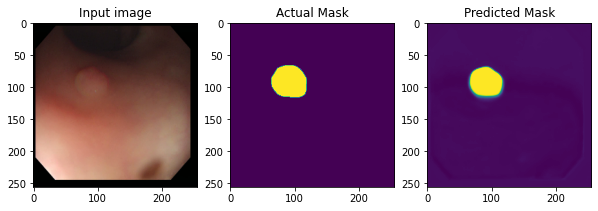

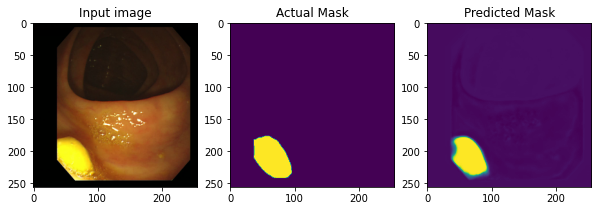

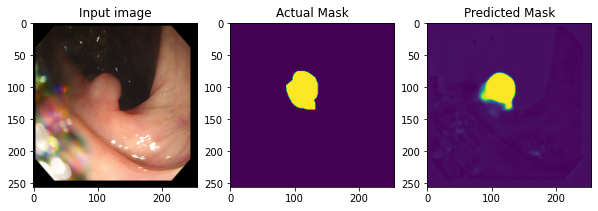

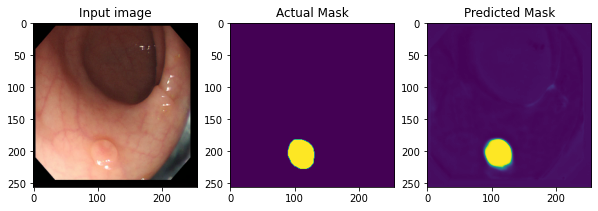

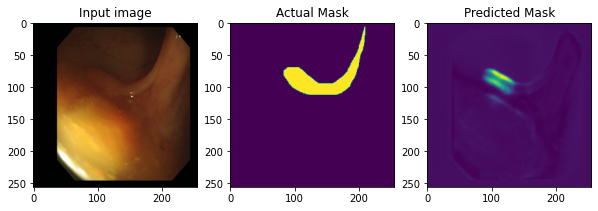

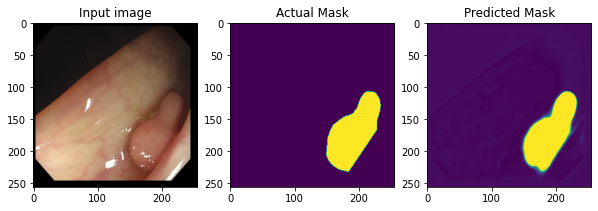

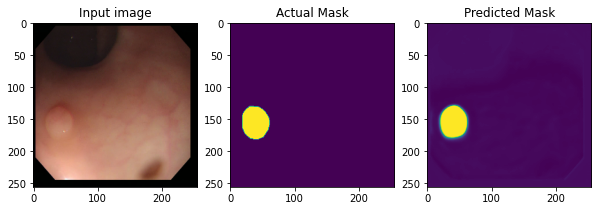

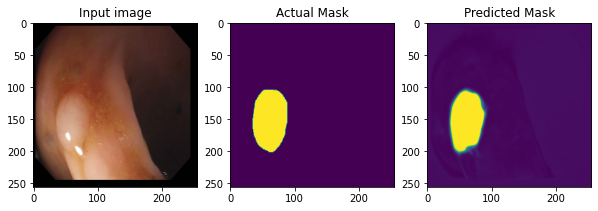

In [50]:
print_images()

## 5-4 : 모델 성능 비교분석

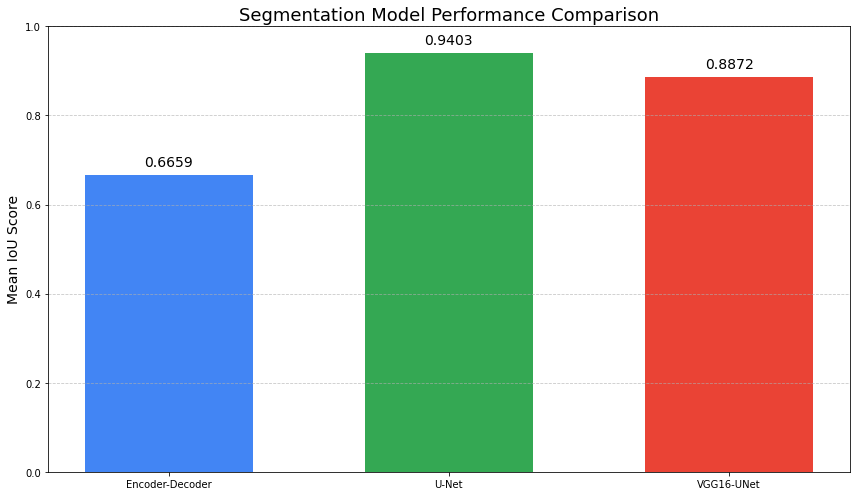

최고 성능 모델: U-Net (IoU: 0.9403)


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 주어진 세 모델의 IoU 값
model_names = ['Encoder-Decoder', 'U-Net', 'VGG16-UNet']
iou_scores = [0.6658949390480631, 0.9403284496029041, 0.8871544134698394]

# 그래프 생성
plt.figure(figsize=(12, 7))
bars = plt.bar(model_names, iou_scores, color=['#4285F4', '#34A853', '#EA4335'], width=0.6)
plt.ylim([0, 1])
plt.title('Segmentation Model Performance Comparison', fontsize=18)
plt.ylabel('Mean IoU Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 바 위에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.4f}', ha='center', fontsize=14)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# 최고 성능 모델 출력
best_model_idx = np.argmax(iou_scores)
print(f"최고 성능 모델: {model_names[best_model_idx]} (IoU: {iou_scores[best_model_idx]:.4f})")

	•	U-Net이 가장 높은 IoU 점수(0.9403) 를 기록함.
	•	VGG16-UNet도 매우 좋은 성능(0.8872)을 보였지만, U-Net보다 약간 낮음.
	•	Encoder-Decoder는 다른 두 모델에 비해 IoU가 많이 떨어짐 (0.6659).


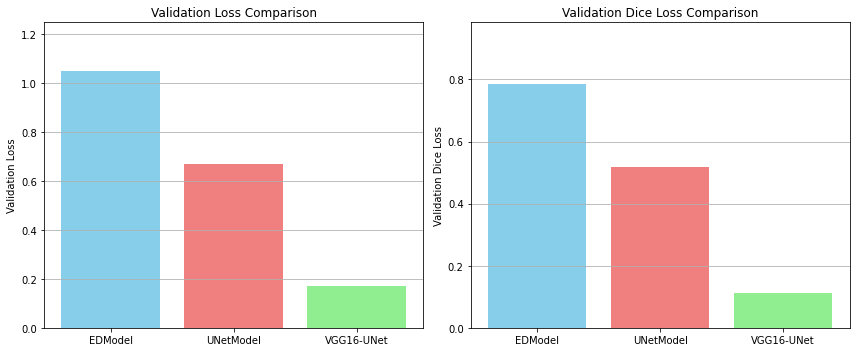

In [3]:
import matplotlib.pyplot as plt

# 모델 이름
models = ['EDModel', 'UNetModel', 'VGG16-UNet']

# val_loss와 val_dice_loss 데이터
val_losses = [1.0470, 0.6688, 0.1690]
val_dice_losses = [0.7836, 0.5190, 0.1134]

# 그래프 그리기
plt.figure(figsize=(12,5))

# Validation Loss 비교
plt.subplot(1, 2, 1)
plt.bar(models, val_losses, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Validation Loss Comparison')
plt.ylabel('Validation Loss')
plt.ylim(0, max(val_losses) + 0.2)
plt.grid(axis='y')

# Validation Dice Loss 비교
plt.subplot(1, 2, 2)
plt.bar(models, val_dice_losses, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Validation Dice Loss Comparison')
plt.ylabel('Validation Dice Loss')
plt.ylim(0, max(val_dice_losses) + 0.2)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

	•	Validation Loss 기준
➔ VGG16-UNet이 가장 낮은 loss를 기록함. <br>

	•	Validation Dice Loss 기준
➔ 마찬가지로 VGG16-UNet이 가장 낮은 dice loss를 기록함.


## ⭐️ 총평 

**“U-Net이 가장 높은 IoU를 기록해 정확도 면에서 최고 성능을 보였고, <br>
VGG16-UNet은 손실 함수 기준 최적의 모델이었지만 정확도 면에서는 U-Net보다 약간 낮았다.”**


**회고 🤦‍♀️: <br>
여러 모델을 한 번에 효율적으로 실행할 수 있는 방법을 고민했지만,
오류 발생으로 인해 커널을 재시작하며 한 모델씩 개별적으로 학습을 진행한 점이 아쉬웠다.
이는 안정성을 고려한 전략적인 선택이었지만, 시스템적인 최적화가 부족했던 점은 보완할 부분이라고 느꼈다.
또한, 체크포인트 파일만으로는 학습 지표를 바로 불러올 수 없어,
직접 수치를 제공해야 했던 점도 역시 아쉬움으로 남았다.**